# DLMI - Lymphocytosis classification
## Many-to-one image model: CNN & Attention

In [1]:
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
from utils import *

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
#data_dir = "/kaggle/input/dlmi-lymphocytosis/dlmi-lymphocytosis-classification/"
data_dir = "../../data/dlmi-lymphocytosis-classification/"
train_dir = data_dir + "trainset/"
test_dir = data_dir + "testset/"
#save_dir = "/kaggle/working/"
save_dir = "checkpoints/"

In [4]:
trainset_true_df = pd.read_csv(data_dir + "trainset/trainset_true.csv")
testset_data_df = pd.read_csv(data_dir + "testset/testset_data.csv")

In [5]:
id_train_val = trainset_true_df["ID"].to_numpy()
labels = trainset_true_df["LABEL"].to_numpy()
labels_dict = dict(zip(id_train_val, labels))

id_train_val_0 = id_train_val[labels == 0]
id_train_val_1 = id_train_val[labels == 1]

val_size = 60
id_val_0 = np.random.choice(id_train_val_0, size=int(val_size * 0.3), replace=False)
id_val_1 = np.random.choice(id_train_val_1, size=int(val_size * 0.7), replace=False)

id_val = np.concatenate([id_val_0, id_val_1])
mask = np.isin(id_train_val, id_val, invert=True)
id_train = id_train_val[mask]

id_train.shape, id_val.shape

((103,), (60,))

In [6]:
batch_size = 1
seq_len = 128

In [7]:
train_dataset = PatientsDataset(
    split_dir=train_dir,
    patients_ids=id_train,
    patients_labels=np.array([labels_dict[id] for id in id_train]),
)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = PatientsDataset(
    split_dir=train_dir,
    patients_ids=id_val,
    patients_labels=np.array([labels_dict[id] for id in id_val]),
)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

train_val_dataset = PatientsDataset(
    split_dir=train_dir,
    patients_ids=id_train_val,
    patients_labels=labels,
)
train_val_dataloader = DataLoader(train_val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = PatientsDataset(
    split_dir=test_dir,
    patients_ids=testset_data_df["ID"].to_numpy(),
    patients_labels=[-1] * len(trainset_true_df["ID"]),
)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
lr = 1e-2
n_epochs = 50
image_size = 96
hidden_dim = 128

model = BagImageModel(
    feature_extractor=FeatureExtractor.CNN,
    feature_aggregator=FeatureAggregator.ATTENTION,
    hidden_dim=hidden_dim,
    num_classes=2,
    attn_num_heads=4,
    image_size=image_size
)
model.to(device)
model_name = "cnn_attn"

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(reduction="sum")

train_transform = torchvision.transforms.Compose([
    torchvision.transforms.CenterCrop(image_size),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.RandomVerticalFlip(p=0.5),
])
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.CenterCrop(image_size),
])

def transform_fn(x, transform):
    x = x.reshape(3, x.shape[0], x.shape[1])
    x = torch.from_numpy(x).to(torch.float32)
    return transform(x)


prediction_aggregator = PredictionAggregator.MIN

Test: 100%|██████████| 60/60 [00:05<00:00, 10.61it/s]


[Epoch 1 / 50]
	train loss = 1.2989 acc = 0.4951 bacc = 0.4707
	test loss = 0.0743 acc = 0.3000 bacc = 0.4683


Test: 100%|██████████| 60/60 [00:05<00:00, 10.77it/s]


[Epoch 2 / 50]
	train loss = 0.0284 acc = 0.6117 bacc = 0.5037
	test loss = 0.0108 acc = 0.7000 bacc = 0.5000


Test: 100%|██████████| 60/60 [00:05<00:00, 10.53it/s]


[Epoch 3 / 50]
	train loss = 0.0116 acc = 0.6893 bacc = 0.5000
	test loss = 0.0901 acc = 0.7000 bacc = 0.5000


Test: 100%|██████████| 60/60 [00:05<00:00, 10.79it/s]


[Epoch 4 / 50]
	train loss = 0.0141 acc = 0.6796 bacc = 0.4930
	test loss = 0.0111 acc = 0.7000 bacc = 0.5000


Test: 100%|██████████| 60/60 [00:05<00:00, 10.65it/s]


[Epoch 5 / 50]
	train loss = 0.0119 acc = 0.6893 bacc = 0.5000
	test loss = 0.0111 acc = 0.7000 bacc = 0.5000


Test: 100%|██████████| 60/60 [00:05<00:00, 10.85it/s]


[Epoch 6 / 50]
	train loss = 0.0119 acc = 0.6893 bacc = 0.5000
	test loss = 0.0113 acc = 0.7000 bacc = 0.5000


Test: 100%|██████████| 60/60 [00:05<00:00, 10.76it/s]


[Epoch 7 / 50]
	train loss = 0.0122 acc = 0.6893 bacc = 0.5000
	test loss = 0.0107 acc = 0.7167 bacc = 0.5278


Test: 100%|██████████| 60/60 [00:05<00:00, 10.82it/s]


[Epoch 8 / 50]
	train loss = 0.0119 acc = 0.6893 bacc = 0.5000
	test loss = 0.0113 acc = 0.7000 bacc = 0.5000


Test: 100%|██████████| 60/60 [00:05<00:00, 10.67it/s]


[Epoch 9 / 50]
	train loss = 0.0120 acc = 0.6893 bacc = 0.5000
	test loss = 0.0113 acc = 0.7000 bacc = 0.5000


Test: 100%|██████████| 60/60 [00:05<00:00, 10.82it/s]


[Epoch 10 / 50]
	train loss = 0.0120 acc = 0.6893 bacc = 0.5000
	test loss = 0.0113 acc = 0.7000 bacc = 0.5000


Test: 100%|██████████| 60/60 [00:05<00:00, 10.68it/s]


[Epoch 11 / 50]
	train loss = 0.0122 acc = 0.6796 bacc = 0.4930
	test loss = 0.0131 acc = 0.7000 bacc = 0.5000


Test: 100%|██████████| 60/60 [00:05<00:00, 10.75it/s]


[Epoch 12 / 50]
	train loss = 0.0122 acc = 0.6893 bacc = 0.5000
	test loss = 0.0114 acc = 0.7000 bacc = 0.5000


Test: 100%|██████████| 60/60 [00:05<00:00, 10.66it/s]


[Epoch 13 / 50]
	train loss = 0.0122 acc = 0.6893 bacc = 0.5000
	test loss = 0.0114 acc = 0.7000 bacc = 0.5000


Test: 100%|██████████| 60/60 [00:05<00:00, 10.91it/s]


[Epoch 14 / 50]
	train loss = 0.0120 acc = 0.6893 bacc = 0.5000
	test loss = 0.0113 acc = 0.7000 bacc = 0.5000


Test: 100%|██████████| 60/60 [00:05<00:00, 10.78it/s]


[Epoch 15 / 50]
	train loss = 0.0122 acc = 0.6893 bacc = 0.5000
	test loss = 0.0113 acc = 0.7000 bacc = 0.5000


Test: 100%|██████████| 60/60 [00:05<00:00, 11.00it/s]


[Epoch 16 / 50]
	train loss = 0.0120 acc = 0.6893 bacc = 0.5000
	test loss = 0.0113 acc = 0.7000 bacc = 0.5000


Test: 100%|██████████| 60/60 [00:05<00:00, 10.80it/s]


[Epoch 17 / 50]
	train loss = 0.0121 acc = 0.6893 bacc = 0.5000
	test loss = 0.0113 acc = 0.7000 bacc = 0.5000


Test: 100%|██████████| 60/60 [00:05<00:00, 10.89it/s]


[Epoch 18 / 50]
	train loss = 0.0185 acc = 0.6893 bacc = 0.5086
	test loss = 0.0112 acc = 0.7000 bacc = 0.5000


Test: 100%|██████████| 60/60 [00:05<00:00, 10.82it/s]


[Epoch 19 / 50]
	train loss = 0.0669 acc = 0.6893 bacc = 0.5086
	test loss = 0.0112 acc = 0.7000 bacc = 0.5000


Test: 100%|██████████| 60/60 [00:05<00:00, 10.87it/s]


[Epoch 20 / 50]
	train loss = 0.0118 acc = 0.6893 bacc = 0.5000
	test loss = 0.0114 acc = 0.7000 bacc = 0.5000


Test: 100%|██████████| 60/60 [00:05<00:00, 10.81it/s]


[Epoch 21 / 50]
	train loss = 0.0133 acc = 0.6893 bacc = 0.5086
	test loss = 0.0115 acc = 0.7000 bacc = 0.5000


Test: 100%|██████████| 60/60 [00:05<00:00, 10.75it/s]


[Epoch 22 / 50]
	train loss = 0.0120 acc = 0.6893 bacc = 0.5000
	test loss = 0.0114 acc = 0.7000 bacc = 0.5000


Test: 100%|██████████| 60/60 [00:05<00:00, 10.63it/s]


[Epoch 23 / 50]
	train loss = 0.0123 acc = 0.6893 bacc = 0.5000
	test loss = 0.0116 acc = 0.7000 bacc = 0.5000


Test: 100%|██████████| 60/60 [00:05<00:00, 10.93it/s]


[Epoch 24 / 50]
	train loss = 0.0121 acc = 0.6893 bacc = 0.5000
	test loss = 0.0114 acc = 0.7000 bacc = 0.5000


Test: 100%|██████████| 60/60 [00:05<00:00, 10.86it/s]


[Epoch 25 / 50]
	train loss = 0.0120 acc = 0.6893 bacc = 0.5000
	test loss = 0.0113 acc = 0.7000 bacc = 0.5000


Test: 100%|██████████| 60/60 [00:05<00:00, 10.87it/s]


[Epoch 26 / 50]
	train loss = 0.0121 acc = 0.6893 bacc = 0.5000
	test loss = 0.0113 acc = 0.7000 bacc = 0.5000


Test: 100%|██████████| 60/60 [00:05<00:00, 10.82it/s]


[Epoch 27 / 50]
	train loss = 0.0121 acc = 0.6893 bacc = 0.5000
	test loss = 0.0113 acc = 0.7000 bacc = 0.5000


Test: 100%|██████████| 60/60 [00:06<00:00,  9.81it/s]


[Epoch 28 / 50]
	train loss = 0.0121 acc = 0.6893 bacc = 0.5000
	test loss = 0.0113 acc = 0.7000 bacc = 0.5000


Test: 100%|██████████| 60/60 [00:05<00:00, 10.82it/s]


[Epoch 29 / 50]
	train loss = 0.0119 acc = 0.6893 bacc = 0.5000
	test loss = 0.0112 acc = 0.7000 bacc = 0.5000


Test: 100%|██████████| 60/60 [00:05<00:00, 10.89it/s]


[Epoch 30 / 50]
	train loss = 0.0122 acc = 0.6893 bacc = 0.5000
	test loss = 0.0113 acc = 0.7000 bacc = 0.5000


Test: 100%|██████████| 60/60 [00:05<00:00, 10.60it/s]


[Epoch 31 / 50]
	train loss = 0.0119 acc = 0.6893 bacc = 0.5000
	test loss = 0.0114 acc = 0.7000 bacc = 0.5000


Test: 100%|██████████| 60/60 [00:05<00:00, 10.97it/s]


[Epoch 32 / 50]
	train loss = 0.0121 acc = 0.6893 bacc = 0.5000
	test loss = 0.0114 acc = 0.7000 bacc = 0.5000


Test: 100%|██████████| 60/60 [00:05<00:00, 10.84it/s]


[Epoch 33 / 50]
	train loss = 234.6111 acc = 0.6602 bacc = 0.4960
	test loss = 1772.9381 acc = 0.7000 bacc = 0.5000


Test: 100%|██████████| 60/60 [00:05<00:00, 10.82it/s]


[Epoch 34 / 50]
	train loss = 36.5525 acc = 0.6893 bacc = 0.5000
	test loss = 0.0112 acc = 0.7000 bacc = 0.5000


Test: 100%|██████████| 60/60 [00:05<00:00, 10.84it/s]


[Epoch 35 / 50]
	train loss = 0.0119 acc = 0.6893 bacc = 0.5000
	test loss = 0.0111 acc = 0.7000 bacc = 0.5000


Test: 100%|██████████| 60/60 [00:05<00:00, 10.81it/s]


[Epoch 36 / 50]
	train loss = 0.0119 acc = 0.6893 bacc = 0.5000
	test loss = 0.0113 acc = 0.7000 bacc = 0.5000


Test: 100%|██████████| 60/60 [00:05<00:00, 10.87it/s]


[Epoch 37 / 50]
	train loss = 0.0121 acc = 0.6893 bacc = 0.5000
	test loss = 0.0114 acc = 0.7000 bacc = 0.5000


Test: 100%|██████████| 60/60 [00:05<00:00, 10.92it/s]


[Epoch 38 / 50]
	train loss = 0.0120 acc = 0.6893 bacc = 0.5000
	test loss = 0.0114 acc = 0.7000 bacc = 0.5000


Test: 100%|██████████| 60/60 [00:05<00:00, 10.83it/s]


[Epoch 39 / 50]
	train loss = 0.0120 acc = 0.6893 bacc = 0.5000
	test loss = 0.0113 acc = 0.7000 bacc = 0.5000


Test: 100%|██████████| 60/60 [00:05<00:00, 10.94it/s]


[Epoch 40 / 50]
	train loss = 0.0122 acc = 0.6893 bacc = 0.5000
	test loss = 0.0115 acc = 0.7000 bacc = 0.5000


Test: 100%|██████████| 60/60 [00:05<00:00, 10.85it/s]


[Epoch 41 / 50]
	train loss = 0.0121 acc = 0.6893 bacc = 0.5000
	test loss = 0.0113 acc = 0.7000 bacc = 0.5000


Test: 100%|██████████| 60/60 [00:05<00:00, 11.03it/s]


[Epoch 42 / 50]
	train loss = 0.0120 acc = 0.6893 bacc = 0.5000
	test loss = 0.0114 acc = 0.7000 bacc = 0.5000


Test: 100%|██████████| 60/60 [00:05<00:00, 10.61it/s]


[Epoch 43 / 50]
	train loss = 0.0121 acc = 0.6893 bacc = 0.5000
	test loss = 0.0113 acc = 0.7000 bacc = 0.5000


Test: 100%|██████████| 60/60 [00:05<00:00, 10.89it/s]


[Epoch 44 / 50]
	train loss = 0.0122 acc = 0.6893 bacc = 0.5000
	test loss = 0.0112 acc = 0.7000 bacc = 0.5000


Test: 100%|██████████| 60/60 [00:05<00:00, 10.85it/s]


[Epoch 45 / 50]
	train loss = 0.0121 acc = 0.6893 bacc = 0.5000
	test loss = 0.0112 acc = 0.7000 bacc = 0.5000


Test: 100%|██████████| 60/60 [00:05<00:00, 10.83it/s]


[Epoch 46 / 50]
	train loss = 0.0119 acc = 0.6893 bacc = 0.5000
	test loss = 0.0112 acc = 0.7000 bacc = 0.5000


Test: 100%|██████████| 60/60 [00:05<00:00, 10.67it/s]


[Epoch 47 / 50]
	train loss = 0.0121 acc = 0.6893 bacc = 0.5000
	test loss = 0.0113 acc = 0.7000 bacc = 0.5000


Test: 100%|██████████| 60/60 [00:05<00:00, 10.86it/s]


[Epoch 48 / 50]
	train loss = 0.0120 acc = 0.6893 bacc = 0.5000
	test loss = 0.0114 acc = 0.7000 bacc = 0.5000


Test: 100%|██████████| 60/60 [00:05<00:00, 10.94it/s]


[Epoch 49 / 50]
	train loss = 0.0120 acc = 0.6893 bacc = 0.5000
	test loss = 0.0114 acc = 0.7000 bacc = 0.5000


Test: 100%|██████████| 60/60 [00:05<00:00, 10.90it/s]


[Epoch 50 / 50]
	train loss = 0.0123 acc = 0.6893 bacc = 0.5000
	test loss = 0.0113 acc = 0.7000 bacc = 0.5000


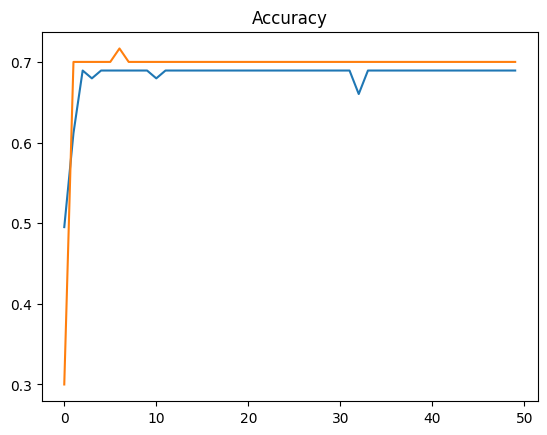

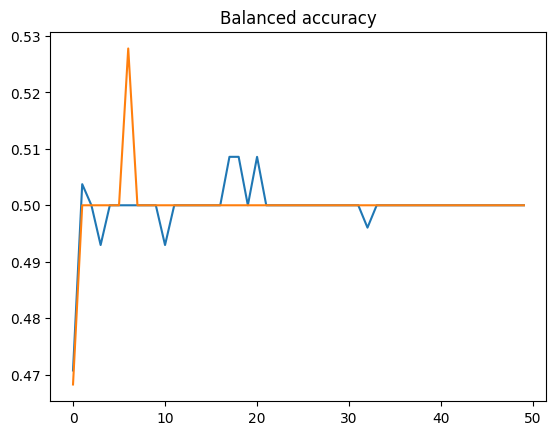

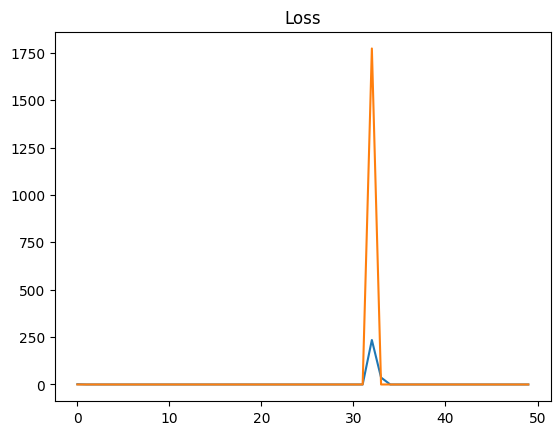

In [9]:
trainer(
    model, 
    optimizer, 
    criterion, 
    train_dataloader, 
    val_dataloader, 
    n_epochs,
    seq_len,
    lambda x: transform_fn(x, train_transform),
    lambda x: transform_fn(x, test_transform),
    prediction_aggregator,
    device,
    model_name,
    verbose=True,
    verbose_every=1,
    save=True,
    save_every=1,
    save_dir=save_dir,
    plot=True
)

In [11]:
all_ids, all_preds = predict(
    model, 
    test_dataloader,
    seq_len,
    lambda x: transform_fn(x, test_transform),
    prediction_aggregator,
    device
)
submission_df = pd.DataFrame({"ID": all_ids, "Predicted": all_preds})
submission_df.to_csv(os.path.join(save_dir, model_name + "01.csv"), index=False)

Predict: 100%|██████████| 42/42 [00:03<00:00, 10.94it/s]
